# Independent Wishart process regression

In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = '1'
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

Setting CUDA visible devices to [1]


In [ ]:
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import blackjax
import jaxkern as jk

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import os
import sys

from blackjax import normal_random_walk
from blackjax.diagnostics import potential_scale_reduction, effective_sample_size

from jaxtyping import Array

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../../../')))

from bamojax.base import Node, Model
from bamojax.sampling import gibbs_sampler, smc_inference_loop, elliptical_slice_nd

from bamojax.more_distributions import GaussianProcessFactory, Zero

print('Python version:       ', sys.version)
print('Jax version:          ', jax.__version__)
print('BlackJax version:     ', blackjax.__version__)
print('Distrax version:      ', dx.__version__)
print('Jax default backend:  ', jax.default_backend())
print('Jax devices:          ', jax.devices())

Python version:        3.10.15 (main, Oct  3 2024, 07:27:34) [GCC 11.2.0]
Jax version:           0.4.35
BlackJax version:      1.2.4
Distrax version:       0.1.5
Jax default backend:   gpu
Jax devices:           [CudaDevice(id=0)]


BaMoJax imports:

## The independent Wishart process

The independent Wishart process is an extension of the generalised Wishart process. Rather than having a single, shared, set of covariance function hyperparameters, in the IWP we have $D$ sets of these (where $D$ is the number of time series, such that $\Sigma(t) \in \mathbb{R}^{D\times D}$). This, in theory, allows the model much more flexibility, but will of course be harder to estimate.


Independent Wishart link functions

In [ ]:
def outer_self_sum(x):
    """ Take the outer product along axis 0.
    
    """
    def outer_self(x_):
        return jnp.outer(x_, x_)
    return jnp.sum(jax.vmap(outer_self, in_axes=(0))(x), axis=0)

#
def vec2tril(v, d=None):
    """ Convert a vector of the d(d+1)/2 elements in the upper triangle (including diagonal) to a triangular matrix.
    
    """
    m = len(v)
    if d is None:
        d = int((-1 + jnp.sqrt(1+8*m))/2)
    L_sample = jnp.zeros((d, d))
    return L_sample.at[jnp.tril_indices(d, 0)].set(v)

#
def get_LFFL(F, L):
    FF = jax.vmap(outer_self_sum, in_axes=(0))(F)    
    return jax.vmap(jnp.matmul,
                    in_axes=(0, None))(jax.vmap(jnp.matmul,
                                                in_axes=(None, 0))(L, FF), L.T)

#
def independent_wishart_transformation(F: Array, L: Array = None, L_vec = None) -> Array:
    r""" Transformes an array of (d, nu, n) Gaussian process draws into an array of (n, d, d) Wishart-distributed covariance matrices.

    Formally, we have

    \Sigma(t) = \sum_{j=1}^\nu L F(t)_j F(t)^T_j L^T.

    It follows from the construction (with GP output variance 1.0) that \Sigma(t) ~ W_d(V, nu), with V the Wishart location and nu its degrees of freedom.

    Args:
        F: An array of size (d, nu, n), with d the number of variables, nu>d the degrees-of-freedom and n the number of timepoints. F[i,j,:] ~ GP(mean, cov_fn)
        L: The Cholesky decomposition of the Wishart location matrix V
        L_vec: The transformed matrix vec(L) for easier sampling.
    Returns:
        LFFL: An array of size (n, d, d)

    """
    d = F.shape[0]
    F = jnp.transpose(F, axes=[2, 1, 0])        
    if L is None and L_vec is not None:
        L = vec2tril(L_vec, d)

    return get_LFFL(F, L)
 
#
def independent_wishart_link_fn(L_vec: Array, shape: tuple, L: Array = None, **Fkwargs) -> dict:
    r""" Transform the (F, L) or (F, vec(L)) representation of the Wishart process into a set of parameters for dx.MultivariateNormalFullCovariance ('loc and covariance_matrix')

    Args:
        F: The (d, nu) draws of a GP, f ~ GP(., .). If the collected f's are flattened, they are reshaped here.
        L / vec(L): The scale matrix of the Wishart distribution.
    Returns:
        A dictionary containing the arguments for a distrax MultivariateNormalFullCovariance distribution object.    
    
    """
    d = len(Fkwargs)
    Fs = []
    for i in range(d):
        Fi = Fkwargs[f'F_{i}']
        if jnp.ndim(Fi) < 2:
            Fi = jnp.reshape(Fi, shape=shape)
        Fs.append(Fi)
    F = jnp.stack(Fs)
    LFFL = independent_wishart_transformation(F=F, L=L, L_vec=L_vec)
    return dict(loc=jnp.zeros((d, )), covariance_matrix=LFFL)

#

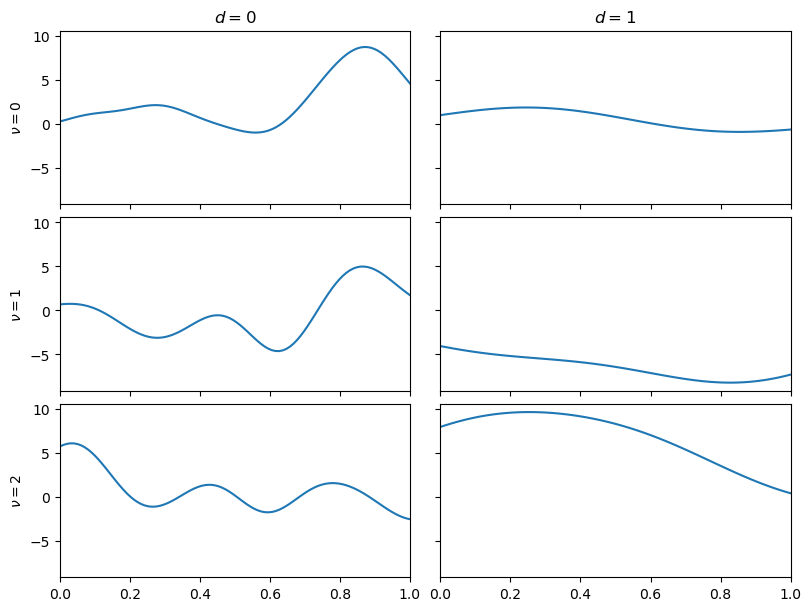

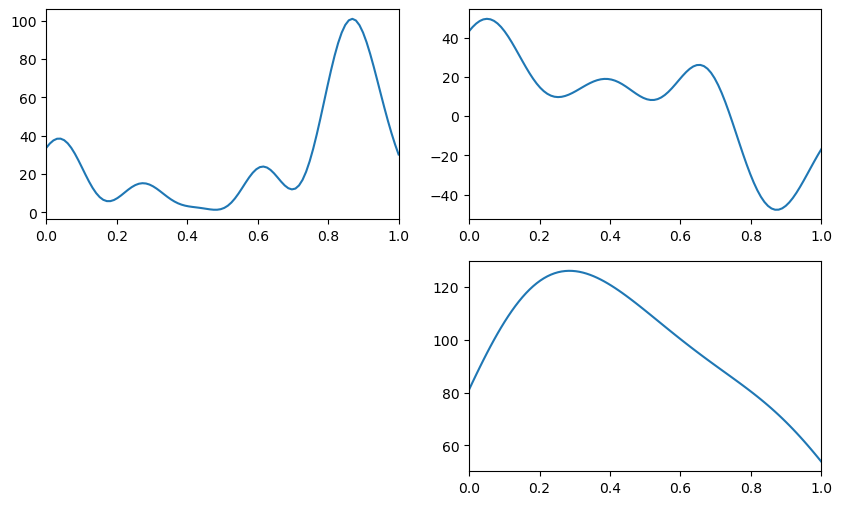

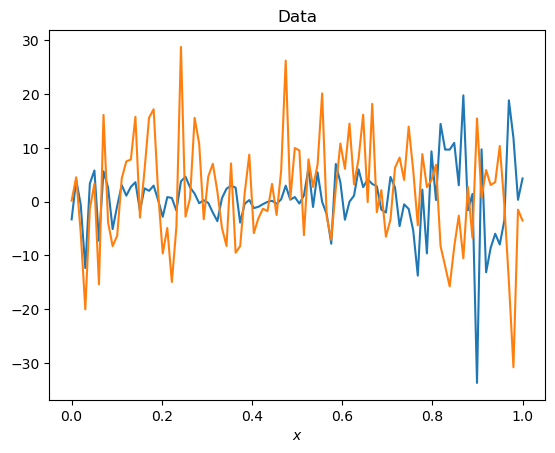

In [ ]:
key = jrnd.PRNGKey(42)

n = 100
cov_fn = jk.RBF()
lengthscales = jnp.array([0.1, 0.3])
d = lengthscales.shape[0]
nu = d + 1
x = jnp.linspace(0, 1, num=n)

F = jnp.zeros((d, nu, n))
for i in range(d):
    subkey = jrnd.fold_in(key, i)
    params = dict(lengthscale=lengthscales[i], variance=1.0)
    K = cov_fn(params, x, x)
    z = jrnd.normal(subkey, shape=(n, nu))
    f = jnp.tensordot(K, z, axes=(1, 0)).T
    F = F.at[i, :, :].set(f)

_, axes = plt.subplots(nrows=nu, ncols=d, sharex=True, sharey=True, constrained_layout=True, figsize=(8, 6))
for i in range(d):
    for j in range(nu):
        axes[j, i].plot(x, F[i, j, :])
    axes[0, i].set_title(fr'$d={i}$')

for ax in axes.flatten():
    ax.set_xlim([0.0, 1.0])
for j, ax in enumerate(axes[:, 0]):
    ax.set_ylabel(fr'$\nu={j}$')

L = jnp.eye(d)

LFFL = get_LFFL(jnp.transpose(F, axes=[2, 1, 0]), L)

_, axes = plt.subplots(nrows=d, ncols=d, figsize=(10, 6))
for i in range(d):
    for j in range(d):
        if i <= j:
            axes[i,j].plot(x, LFFL[:, i, j])
        else:
            axes[i,j].axis('off')
for ax in axes.flatten():
    ax.set_xlim([0.0, 1.0])


Y = jnp.zeros((n, d))
for t in range(n):
    key, subkey = jrnd.split(key)
    Y = Y.at[t,:].set(jrnd.multivariate_normal(subkey, mean=jnp.zeros((d, )), cov=LFFL[t, :, :]))

plt.figure()
plt.plot(x, Y)
plt.xlabel(r'$x$')
plt.title('Data');

In [ ]:
n, d = Y.shape
nu = d + 1
m = int(d*(d+1)/2)
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]

partial_wishart_link_fn = lambda L_vec, **Fkwargs: independent_wishart_link_fn(L_vec=L_vec, shape=(nu, n), **Fkwargs)

IWP = Model('Independent Wishart process')
x_node = IWP.add_node(name='input', observations=x)
Fs = []
for i in range(d):
    ls_node = IWP.add_node(name=f'lengthscale_{i}', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
    F_node = IWP.add_node(name=f'F_{i}', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=jk.RBF()), 
                       parents=dict(input=x_node, 
                                    lengthscale=ls_node, 
                                    variance=1.0), shape=(nu, ))  # this probably isn't implemented correctly yet!
    Fs.append(F_node)
F_parents_dict = {fnode.name: fnode for fnode in Fs}
Lvec = IWP.add_node(name='L_vec', distribution=dx.Normal(loc=jnp.zeros((m, )), scale=jnp.ones((m, ))))
y_node = IWP.add_node(name='Y', 
                      distribution=dx.MultivariateNormalFullCovariance, 
                      parents=dict(L_vec=Lvec, **F_parents_dict), 
                      link_fn=partial_wishart_link_fn, 
                      observations=Y)

In [ ]:
%%time

from bamojax.sampling import elliptical_slice_nd

step_fns = dict(L_vec=normal_random_walk)
step_fn_params = dict(L_vec=dict(sigma=0.05*jnp.eye(m)))

# set the Gibbs steps per latent variable
for i in range(d):
    F_key = f'F_{i}'
    step_fns[F_key] = elliptical_slice_nd
    step_fn_params[F_key] = dict(implied_mvn_prior=True, name='elliptical_slice_nd', nd=(nu, ))
    ell_key = f'lengthscale_{i}'
    step_fns[ell_key] = normal_random_walk
    step_fn_params[ell_key] = dict(sigma=0.01)

gibbs = gibbs_sampler(IWP, step_fns=step_fns, step_fn_params=step_fn_params)

key = jrnd.PRNGKey(1234)
key, subkey = jrnd.split(key)
final_state, lml, n_iter, final_info = smc_inference_loop(subkey, IWP, kernel=gibbs, num_particles=1000, num_mcmc_steps=200)

for node in ['lengthscale_0', 'lengthscale_1', 'L_vec']:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

Acceptance rate for lengthscale_0: 0.199
Acceptance rate for lengthscale_1: 0.969
Acceptance rate for L_vec: 0.957
CPU times: user 18min 59s, sys: 2.66 s, total: 19min 2s
Wall time: 18min 55s


Save intermediate results to save time:

In [ ]:
import pickle

filepath = '/home/maxhin/Documents/Data/bamojax_intermediate/iwp_sim_results.pkl'
results_dict = dict(final_state=final_state, lml=lml, n_iter=n_iter, final_info=final_info, LFFL=LFFL, lengthscales=lengthscales, L=L)

with open(filepath, 'wb') as file:
    pickle.dump(results_dict, file)

Load results:

In [16]:
import pickle

filepath = '/home/maxhin/Documents/Data/bamojax_intermediate/iwp_sim_results.pkl'

with open(filepath, "rb") as file:
    results_dict = pickle.load(file)

We get memory trouble if we take too many MCMC steps within SMC; can we temper more slowly?

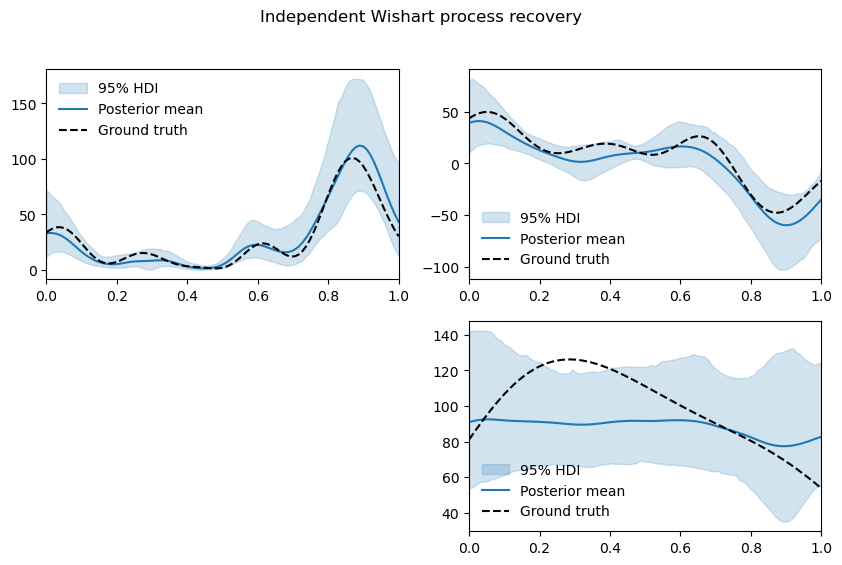

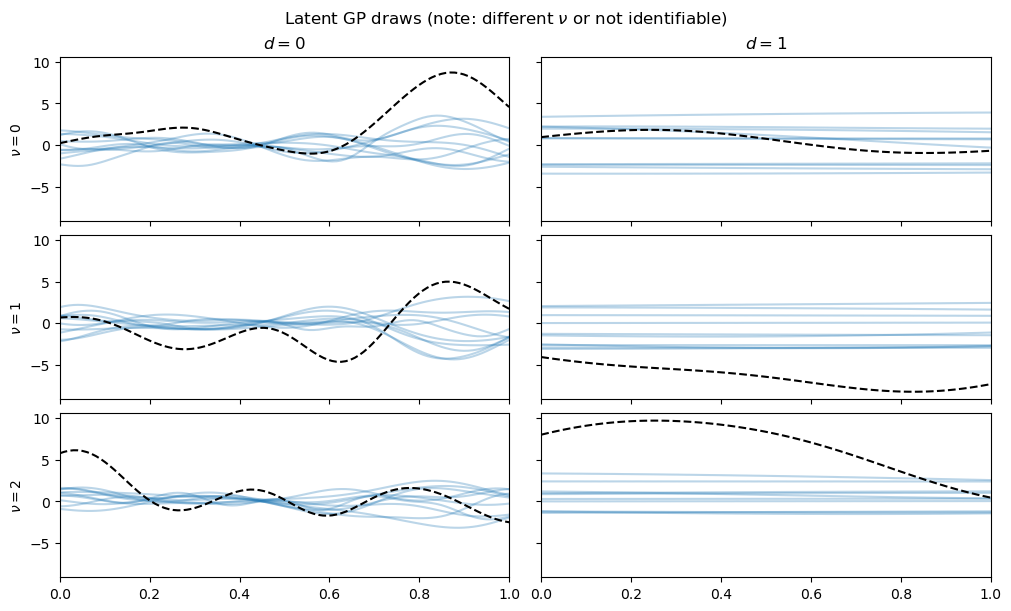

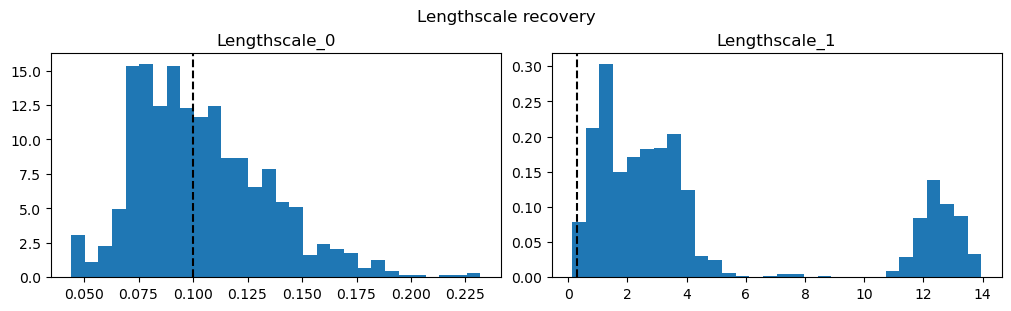

In [18]:
def wrapper_LFFL(particle):
    Lvec = particle['L_vec']
    Fs = []
    for i in range(d):
        Fi = particle[f'F_{i}']
        if jnp.ndim(Fi) < 2:
            Fi = jnp.reshape(Fi, shape=(nu, n))
        Fs.append(Fi)
    F = jnp.stack(Fs)
    LFFL = independent_wishart_transformation(F=F, L_vec=Lvec)
    return LFFL

#  
def wrapper_F(particle):
    Fs = []
    for i in range(d):
        Fi = particle[f'F_{i}']
        if jnp.ndim(Fi) < 2:
            Fi = jnp.reshape(Fi, shape=(nu, n))
        Fs.append(Fi)
    F = jnp.stack(Fs)
    return F

#   

LFFL_samples = jax.vmap(wrapper_LFFL)(results_dict['final_state'].particles)
LFFL_mean = jnp.mean(LFFL_samples, axis=0)
LFFL_95_bnd = jnp.quantile(LFFL_samples, q=jnp.array([0.025, 0.975]), axis=0)


_, axes = plt.subplots(nrows=d, ncols=d, figsize=(10, 6))
for i in range(d):
    for j in range(d):
        if i <= j:
            axes[i,j].fill_between(x.flatten(), LFFL_95_bnd[0, :, i, j], LFFL_95_bnd[1, :, i, j], alpha=0.2, color='tab:blue', label='95% HDI')
            axes[i,j].plot(x, LFFL_mean[:, i, j], color='tab:blue', label='Posterior mean')
            axes[i,j].plot(x, LFFL[:, i, j], color='k', label='Ground truth', ls='--')
            axes[i,j].legend(frameon=False)
        else:
            axes[i,j].axis('off')
for ax in axes.flatten():
    ax.set_xlim([0.0, 1.0])
plt.suptitle('Independent Wishart process recovery')

##

F_samples = jax.vmap(wrapper_F)(results_dict['final_state'].particles)
F_mean = jnp.mean(F_samples, axis=0)
F_95_bnd = jnp.quantile(F_samples, q=jnp.array([0.025, 0.975]), axis=0)

ix = jrnd.randint(subkey, shape=(10,), minval=0, maxval=F_samples.shape[0])

_, axes = plt.subplots(nrows=nu, ncols=d, sharex=True, sharey=True, constrained_layout=True, figsize=(10, 6))
for i in range(d):
    for j in range(nu):  
        axes[j, i].plot(x, F_samples[ix, i, j, :].T, color='tab:blue', alpha=0.3)
        axes[j, i].plot(x, F[i, j, :], color='k', ls='--')
    axes[0, i].set_title(fr'$d={i}$')

for ax in axes.flatten():
    ax.set_xlim([0.0, 1.0])
for j, ax in enumerate(axes[:, 0]):
    ax.set_ylabel(fr'$\nu={j}$')

plt.suptitle(r'Latent GP draws (note: different $\nu$ or not identifiable)');

_, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10, 3))
for i in range(d):
    axes[i].hist(results_dict['final_state'].particles[f'lengthscale_{i}'], density=True, bins=30)
    axes[i].set_title(f'Lengthscale_{i}')
    axes[i].axvline(x=lengthscales[i], color='k', ls='--')
    
plt.suptitle('Lengthscale recovery');

---

Do we implement the sequence of parents as a list or dict or a new structure entirely?

In [4]:
import numpy as np
import yfinance as yf

print('Download timeseries')
data = yf.download("^GDAXI ^GSPC", start="2017-09-10", end="2022-09-10", interval="1d")

close = data["Close"]
returns = np.log(close).diff().dropna()

Y = jnp.asarray(returns.iloc[0:-1:10, :])
time = returns.index[0:-1:10]

Download timeseries


[*********************100%***********************]  2 of 2 completed


In [ ]:
n, d = Y.shape
nu = d + 1
m = int(d*(d+1)/2)
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]

partial_wishart_link_fn = lambda L_vec, **Fkwargs: independent_wishart_link_fn(L_vec=L_vec, shape=(nu, n), **Fkwargs)

IWP = Model('Independent Wishart process')
x_node = IWP.add_node(name='input', observations=x)
Fs = []
for i in range(d):
    ls_node = IWP.add_node(name=f'lengthscale_{i}', distribution=dx.Transformed(dx.Normal(loc=0., scale=1.), tfb.Exp()))
    F_node = IWP.add_node(name=f'F_{i}', distribution=GaussianProcessFactory(mean_fn=Zero(), cov_fn=jk.RBF()), 
                       parents=dict(input=x_node, 
                                    lengthscale=ls_node, 
                                    variance=1.0), shape=(nu, ))  # this probably isn't implemented correctly yet!
    Fs.append(F_node)
F_parents_dict = {fnode.name: fnode for fnode in Fs}
Lvec = IWP.add_node(name='L_vec', distribution=dx.Normal(loc=jnp.zeros((m, )), scale=jnp.ones((m, ))))
y_node = IWP.add_node(name='Y', 
                      distribution=dx.MultivariateNormalFullCovariance, 
                      parents=dict(L_vec=Lvec, **F_parents_dict), 
                      link_fn=partial_wishart_link_fn, 
                      observations=Y)

Set up Gibbs sampling within SMC for IWP:

There is interaction between the different variables and hence step sizes. How to provide heuristics here?

In [ ]:
%%time

from bamojax.sampling import elliptical_slice_nd

step_fns = dict(L_vec=normal_random_walk)
step_fn_params = dict(L_vec=dict(sigma=0.001*jnp.eye(m)))

# set the Gibbs steps per latent variable
for i in range(d):
    F_key = f'F_{i}'
    step_fns[F_key] = elliptical_slice_nd
    step_fn_params[F_key] = dict(implied_mvn_prior=True, name='elliptical_slice_nd', nd=(nu, ))
    ell_key = f'lengthscale_{i}'
    step_fns[ell_key] = normal_random_walk
    step_fn_params[ell_key] = dict(sigma=0.005)

gibbs = gibbs_sampler(IWP, step_fns=step_fns, step_fn_params=step_fn_params)

key = jrnd.PRNGKey(1234)
key, subkey = jrnd.split(key)
final_state, lml, n_iter, final_info = smc_inference_loop(subkey, IWP, kernel=gibbs, num_particles=1000, num_mcmc_steps=300)

for node in ['lengthscale_0', 'lengthscale_1', 'L_vec']:
    print(f'Acceptance rate for {node}: {jnp.mean(final_info.update_info[node].is_accepted):0.3f}')

Acceptance rate for lengthscale_0: 0.971
Acceptance rate for lengthscale_1: 0.976
Acceptance rate for L_vec: 0.293
CPU times: user 19min 54s, sys: 2.09 s, total: 19min 56s
Wall time: 19min 56s


In [ ]:
import pickle

filepath = '/home/maxhin/Documents/Data/bamojax_intermediate/iwp_finance_results.pkl'
results_dict = dict(final_state=final_state, lml=lml, n_iter=n_iter, final_info=final_info)

with open(filepath, 'wb') as file:
    pickle.dump(results_dict, file)

In [6]:
import pickle

filepath = '/home/maxhin/Documents/Data/bamojax_intermediate/iwp_finance_results.pkl'

with open(filepath, "rb") as file:
    results_dict = pickle.load(file)

Visualize model fit:

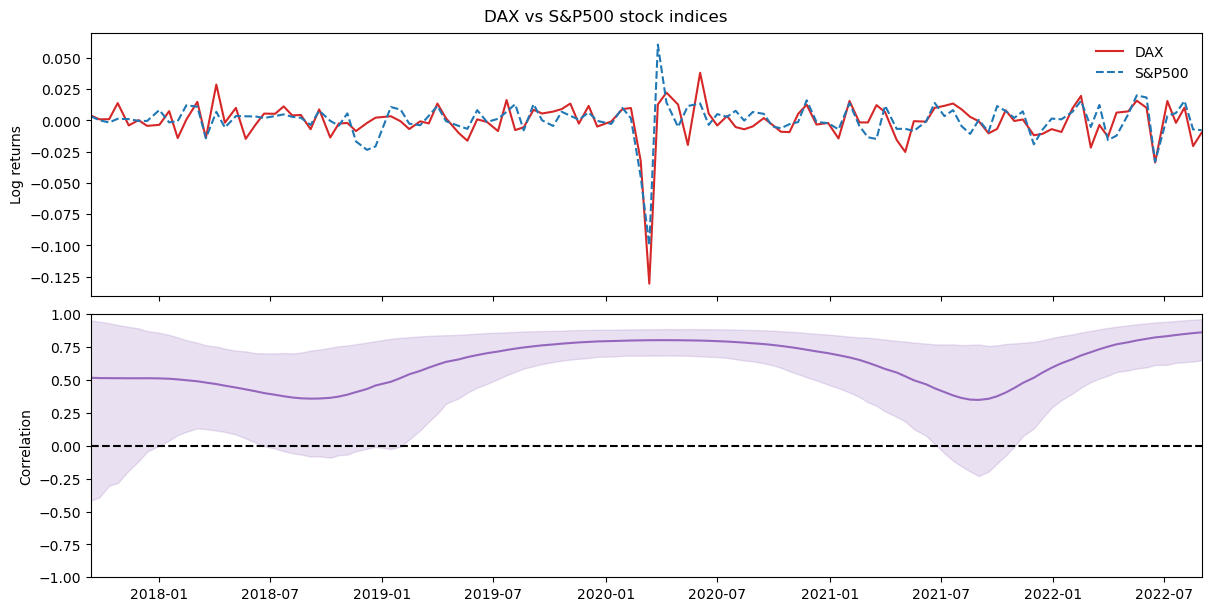

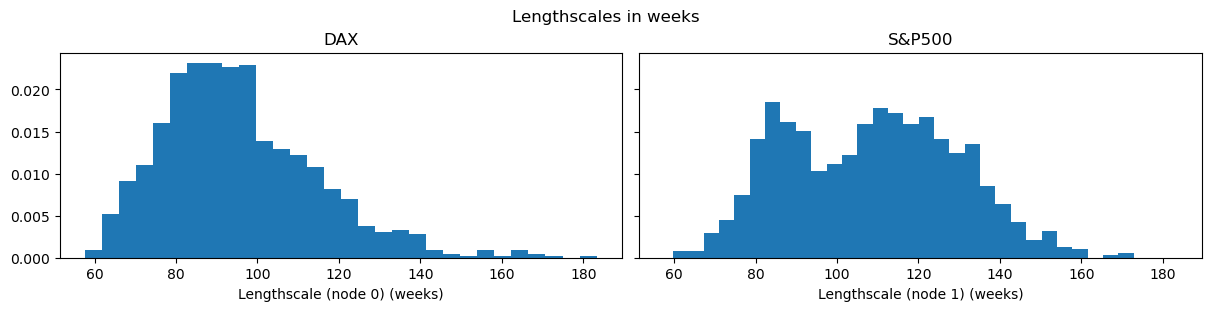

In [ ]:
def cov2corr(Sigma):
    v = jnp.sqrt(jnp.diag(Sigma))
    outer_v = jnp.outer(v, v)
    correlation = Sigma / outer_v
    return correlation

#

def wrapper(particle):
    Lvec = particle['L_vec']
    Fs = []
    for i in range(d):
        Fi = particle[f'F_{i}']
        if jnp.ndim(Fi) < 2:
            Fi = jnp.reshape(Fi, shape=(nu, n))
        Fs.append(Fi)
    F = jnp.stack(Fs)
    LFFL = independent_wishart_transformation(F=F, L_vec=Lvec)
    return LFFL

#
    

LFFL_samples = jax.vmap(wrapper)(results_dict['final_state'].particles)
corr_samples = jax.vmap(jax.vmap(cov2corr, in_axes=0), in_axes=0)(LFFL_samples)

corr_mean = jnp.mean(corr_samples, axis=0)
corr_95 = jnp.quantile(corr_samples, q=jnp.array([0.025, 0.975]), axis=0)

_, axes = plt.subplots(nrows=2, ncols=1, sharex=True, constrained_layout=True, figsize=(12, 6))
axes[0].plot(time, Y[:,0], label='DAX', color='tab:red')
axes[0].plot(time, Y[:,1], label='S&P500', color='tab:blue', ls='--')
axes[0].legend(frameon=False)
axes[0].set_ylabel('Log returns')
axes[1].plot(time, corr_mean[:, 0, 1], color='tab:purple')
axes[1].fill_between(time, corr_95[0, :, 0, 1], corr_95[1, :, 0, 1], color='tab:purple', alpha=0.2)
axes[1].set_ylabel('Correlation')
axes[1].set_ylim([-1.0, 1.0])
axes[1].axhline(y=0.0, ls='--', color='k')
for ax in axes:
    ax.set_xlim([time[0], time[-1]])
plt.suptitle('DAX vs S&P500 stock indices')

_, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(12, 3), sharex=True, sharey=True)
for i, ax in enumerate(axes):
    ax.hist(results_dict['final_state'].particles[f'lengthscale_{i}']*(time[-1] - time[0]).days/7, bins=30, density=True)  # converted to weeks
    ax.set_xlabel(f'Lengthscale (node {i}) (weeks)')
axes[0].set_title('DAX')
axes[1].set_title('S&P500')
plt.suptitle('Lengthscales in weeks');

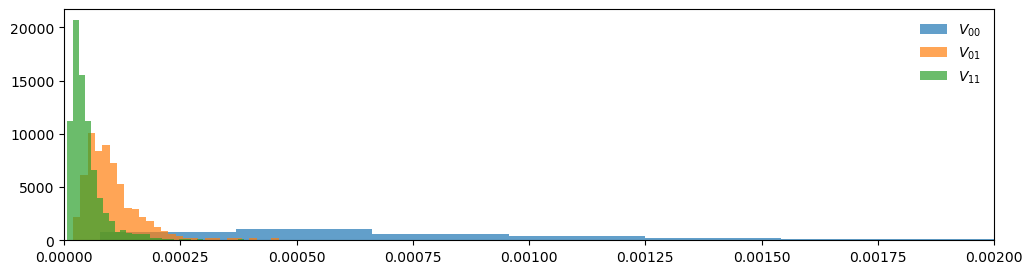

In [31]:
def L2V(Lvec):
    L = vec2tril(Lvec, 2)
    V = jnp.dot(L.T, L)
    return V

#
V_samples = jax.vmap(L2V)(results_dict['final_state'].particles['L_vec'])

plt.figure(figsize=(12, 3))
plt.hist(V_samples[:, 0, 0], density=True, alpha=0.7, bins=30, label=r'$V_{00}$')
plt.hist(V_samples[:, 0, 1], density=True, alpha=0.7, bins=30, label=r'$V_{01}$')
plt.hist(V_samples[:, 1, 1], density=True, alpha=0.7, bins=30, label=r'$V_{11}$')
plt.legend(frameon=False)
plt.xlim([0, 0.002]);

Note the distributions are all on really small values - perhaps we should standardize $Y$ first? This might lead to easier tuning of acceptance rates.

## Posterior correlations between parameters

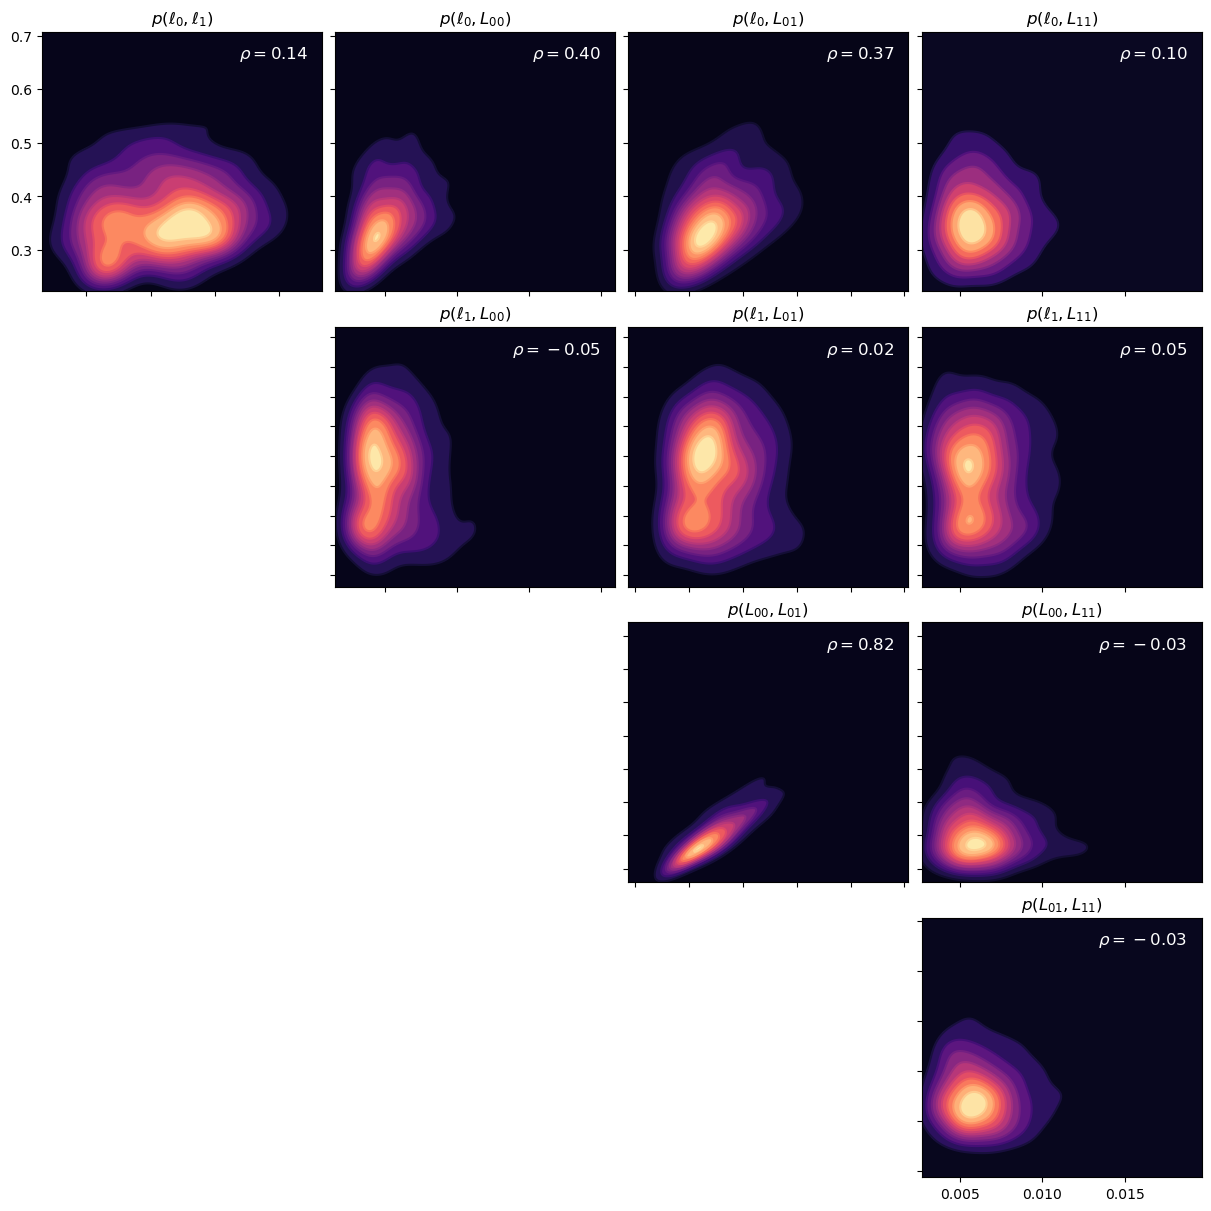

In [96]:
from jax.scipy.stats import gaussian_kde

scalar_estimates = jnp.stack([results_dict['final_state'].particles['lengthscale_0'], 
                              results_dict['final_state'].particles['lengthscale_1'], 
                              results_dict['final_state'].particles['L_vec'][:, 0],
                              results_dict['final_state'].particles['L_vec'][:, 1],
                              results_dict['final_state'].particles['L_vec'][:, 2]])

num_scalars = scalar_estimates.shape[0]

grid_res = 200

labels = ['\ell_0', '\ell_1', 'L_{00}', 'L_{01}', 'L_{11}']

_, axes = plt.subplots(nrows=num_scalars-1, ncols=num_scalars-1, figsize=(12, 12), constrained_layout=True, sharey='row', sharex='col')
for i in range(0, num_scalars-1):
    for j in range(0, num_scalars-1):
        if i < j + 1:
            x = scalar_estimates[j+1]
            y = scalar_estimates[i]
            xmin, xmax = jnp.min(x), jnp.max(x)
            ymin, ymax = jnp.min(y), jnp.max(y)
            pdf = gaussian_kde(jnp.vstack([x, y]))
            xx, yy = jnp.meshgrid(jnp.linspace(xmin, xmax, grid_res), jnp.linspace(ymin, ymax, grid_res))
            plt_pts = jnp.vstack([xx.flatten(), yy.flatten()])
            z = pdf(plt_pts).reshape(grid_res, grid_res)
            axes[i, j].contourf(xx, yy, z, cmap='magma', levels=10)
            axes[i, j].contour(xx, yy, z, cmap='magma', levels=10)
            rho = jnp.corrcoef(jnp.stack([x, y]))[0, 1]
            axes[i, j].text(x=0.95, y=0.95, transform=axes[i, j].transAxes, s=fr'$\rho = {rho:0.2f}$', ha='right', va='top', color='w', fontsize=12)
            axes[i, j].set_title(fr'$p({labels[i]}, {labels[j+1]})$')
        else:
            axes[i, j].axis('off')


Note how some elements of the scale matrix are very strongly correlated.